In [29]:
using ITensors
using ITensorNetworks
using Graphs
using Observers
using Printf
# using ITensors.HDF5
using TupleTools
import Random

# using PyPlot
# push!(LOAD_PATH,pwd())
include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


mmax, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick.yml"; default_filename="psi0_N6_g")

###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(mmax)
Xtmp = Xoperator(mmax)
Ytmp = Yoperator(mmax)
Uptmp = Upoperator(mmax)
Downtmp = Downoperator(mmax)
mInverttmp = MInversionOperator(mmax)
SmallEProjtmp = SmallEnergyProjector(mmax; m=1)

use_parity_symmetry = (parity_symmetry_type == "even" || parity_symmetry_type == "odd")
if use_parity_symmetry
    symmetry=parity_symmetry
else
    symmetry=trivial_symmetry
end

#Define basis#
if evod == "dvr"
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(mmax))
	global T = symmetry(tmp1)
	global X = symmetry(tmp2)
	global Y = symmetry(tmp3)

	Nspec=size(T,1)
else 
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
	global mInvert = symmetry(mInverttmp)
	global SmallEProj = symmetry(SmallEProjtmp)

	Nspec=size(T,1)
end

#Determine number of interaction pairs per starting site#
Nsecond = zeros(Int64,(Nsites-1))
for i=1:Nsites-1
	if pairs == "nearest"
		Nsecond[i]=i+1
	elseif pairs == "allpairs"
		Nsecond[i]=Nsites
	end
end

include("operators.jl")
include("observer.jl")

if evod == "dvr"
    fac1 = 1.0
    fac2 = 1.0
else 
    fac1 = -1.0
    fac2 = 1.0im
end

g = 1.1

sites = siteinds("PlaRotor",Nsites;dim=Nspec, conserve_parity=use_parity_symmetry, conserve_L=false)

Random.seed!(1234)
if parity_symmetry_type == "even"
	psi = randomMPS(sites,[1 for i in 1:Nsites]; linkdims=50)
elseif parity_symmetry_type == "odd"
	psi = randomMPS(sites,[[1 for i in 1:Nsites-1]..., 2*mmax]; linkdims=50)
else
	psi = randomMPS(sites; linkdims=50)
end
# psi = MPS(sites, [1 for i in 1:Nsites])

function create_Hamiltonian(g, sites, Nsecond; Estrength=0,angle=0, fac1=1, fac2=1)
	Nsites = length(sites)
	ampo = AutoMPO()
	for i=1:Nsites-1
		ampo += 1.0,"T",i
		for j=i+1:Nsecond[i]
			c=g/((abs(j-i))^3)
			if evod == "dvr"
				# y_iy_j#
				ampo += 1.0*c*fac1,"Y",i,"Y",j
				# 2*x_ix_j#
				ampo += -2.0*c,"X",i,"X",j
			else
				# up up
				ampo +=-.75*c,"Up",i,"Up",j
				# up down
				ampo +=-.25*c,"Up",i,"Down",j
				# down up 
				ampo +=-.25*c,"Down",i,"Up",j
				# down down
				ampo +=-.75*c,"Down",i,"Down",j
			end
		end
		#Electric field#
		
		if !iszero(Estrength)
			ampo += -cos(angle)*Estrength,"X",i
			ampo += -sin(angle)*Estrength*fac2,"Y",i
		end
	end
	ampo += 1.0,"T",Nsites
	#Electric field#

	if !iszero(Estrength)
		ampo += -cos(angle)*Estrength,"X",Nsites
		ampo += -sin(angle)*Estrength*fac2,"Y",Nsites
	end

	H = MPO(ampo,sites)
	return H
end

create_Hamiltonian (generic function with 1 method)

In [52]:
function find_mapping(mat)
    mapping = []
    rows = size(mat)[1]
    for i=1:rows
        index = argmax(abs.(mat[:,i]))
        if abs(mat[index, i]) < 0.3
            push!(mapping, nothing)
        else
            push!(mapping, index)
        end
    end
    return mapping
end


sweeps = Sweeps(30)
maxdim!(sweeps,20)
setcutoff!(sweeps, 1e-10)

excitation_number = 20
Tij = zeros(excitation_number, excitation_number)
previous_eigenstates = MPS[]
prev_x = nothing
energies = []
g_values = []
connection = []


Hij = zeros(excitation_number, excitation_number)
Sij = zeros(excitation_number, excitation_number) # we want H x = lambda S x
tmp = zeros(excitation_number, excitation_number)

for g=0.3:0.3:0.6
    H = create_Hamiltonian(g, sites, Nsecond)
    energy_eigenstates = MPS[]

    push!(g_values, g)
    # finding excited state with DMRG
    for i in 1:excitation_number
        energy, ψ = dmrg(H,energy_eigenstates, psi, sweeps;outputlevel=0, weight=30)
        push!(energy_eigenstates, ψ)
    end
    # compute <i|H|j> and <i|j>
    for i in 1:excitation_number
        for j in 1:excitation_number
            Hij[i,j] = inner(energy_eigenstates[i], apply(H, energy_eigenstates[j]))
            Sij[i,j] = inner(energy_eigenstates[i], energy_eigenstates[j])
        end
    end
    # compute generalized eigenvalue problem to rediagonalize
    F = eigen(Hij, Sij)
    push!(energies, F.values)

    # comparing new eigenstates with previous to see which they map to
    if length(previous_eigenstates) > 0
        for i in 1:excitation_number
            for j in 1:excitation_number
                Tij[i,j] = inner(energy_eigenstates[i], previous_eigenstates[j])
            end
        end
        tmp = F.vectors

        push!(connection, find_mapping(F.vectors' * Tij *prev_x))
    else
        push!(connection, nothing)
    end
    prev_x = F.vectors
    previous_eigenstates = copy(energy_eigenstates)
end

In [61]:
energies[2]

20

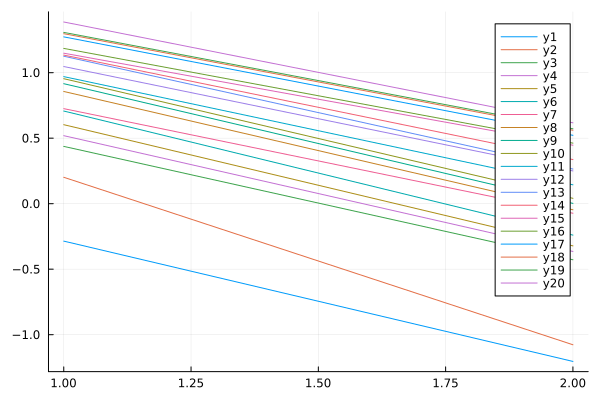

In [65]:
using Plots

plot(hcat(energies...)')

In [53]:
connection

2-element Vector{Any}:
 nothing
 Any[1, 2, 3, 4, 6, 10, 9, 12, 5, 15, 16, 20, 7, 8, nothing, 11, nothing, 13, 14, 17]

In [50]:
find_mapping(tmp' * Tij *prev_x)

5-element Vector{Any}:
 1
 2
 3
 4
  nothing